The goal here is to demonstrate that we can locate validation events from their correlations. 



In [1]:
import numpy as np
from sigvisa import Sigvisa

from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region
from sigvisa.source.event import get_event

import cPickle as pickle

from sigvisa.utils.geog import dist_km

%matplotlib inline
import matplotlib.pylab as plt

from sigvisa.signals.common import Waveform

from sigvisa.explore.correlate_validation_events import load_arrivals
from sigvisa.explore.correlate_validation_events_align import build_sg, proposal_xc, locate_event, get_prior_nm

from sigvisa.infer.correlations.weighted_event_posterior import hack_ev_time_posterior_with_weight, compute_atime_posteriors
from sigvisa.infer.correlations.historical_signal_library import get_historical_signals
from sigvisa.infer.correlations.event_proposal import compute_proposal_distribution

In [4]:
# build a timespec SG with the first hour of Wells validation data

def build_sg(stas, evid, phases=None):

    runid = 17
    hz=10.0
    uatemplate_rate=4e-4
    bands=["freq_0.8_4.5"]
    if phases is None:
        phases=["Pn", "Sn", "Lg", "Pg"]
    hack_constraint = True
    raw_signals = True

    region_lon = (-126, -100)
    region_lat = (32, 49)

    runids=(runid,)

    rs = EventRunSpec(stas=stas, evids=[evid,])

    ev = get_event(evid)
    region_stime = ev.time - 150
    region_etime = ev.time + 200
    region = Region(lons=region_lon, lats=region_lat,
                    times=(region_stime, region_etime),
                    rate_bulletin="isc",
                    min_mb=2.0,
                    rate_train_start=1167609600,
                    rate_train_end=1199145600)


    ms1 = ModelSpec(template_model_type="gpparam",
                    wiggle_family="db4_2.0_3_20.0",
                    wiggle_model_type="gplocal+lld+none",
                    uatemplate_rate=uatemplate_rate,
                    max_hz=hz,
                    phases=phases,
                    bands=bands,
                    runids=runids,
                    inference_region=region,
                    dummy_fallback=False,
                    raw_signals=raw_signals,
                    hack_param_constraint=hack_constraint,
                    vert_only=True)

    sg = rs.build_sg(ms1)
    return sg

In [5]:
from sigvisa.models.distributions import Gaussian
from sigvisa.plotting.event_heatmap import EventHeatmap

def extract_wavelet_posterior(wn, eid, phase):
    # extract phase signal for neighbor wn
    d = wn.get_value().data
    ell, marginals, step_ells = wn.tssm.all_filtered_cssm_coef_marginals(d)
    for i, (eid, pphase, scale, sidx, npts, component_type) in enumerate(wn.tssm_components):
        if component_type != "wavelet": continue
        if pphase!=phase: continue
        wmeans, wvars = marginals[i]
        break
    return wmeans, wvars


proposal using correlation True
proposal using correlation True
proposal using correlation True
proposal using correlation True
reading station detections... 


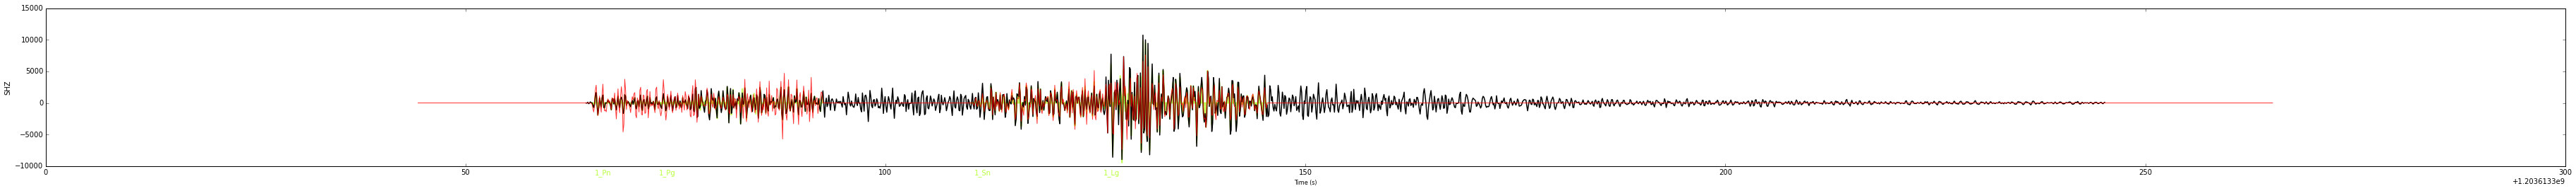

In [8]:
from sigvisa.infer.event_birthdeath import ev_template_birth_helper

train_evids = np.loadtxt("/home/dmoore/python/sigvisa/train_clusters/cluster_017")
validation_evids = np.loadtxt("/home/dmoore/python/sigvisa/notebooks/thesis/validation_evids.txt")

s = Sigvisa()


stas = ["NVAR",]
phases=["Pn", "Sn", "Lg", "Pg"]
evid = 3375254


sg = build_sg(stas, evid=evid, phases=phases)
ev = get_event(evid)
sg.add_event(ev, phases=None)
wn = sg.station_waves["NV01"][0]


lqf, replicate_tmpls, birth_records = \
        ev_template_birth_helper(sg, 1,
                                 associate_using_mb=True,
                                 use_correlation=True,
                                 proposal_type="smart")
f = plt.figure(figsize=(64, 4))
ax = f.add_subplot(111)
wn.plot(ax=ax, plot_pred=True, model_lw=0)


    

In [33]:
def is_wells_event(evid):
    ev = get_event(evid)
    return (-115.5 < ev.lon < -114 and 40.5 < ev.lat < 41.8)

train_evids = np.loadtxt("/home/dmoore/python/sigvisa/notebooks/thesis/train_evids.txt")
validation_evids = np.loadtxt("/home/dmoore/python/sigvisa/notebooks/thesis/validation_evids.txt")
test_evids = np.loadtxt("/home/dmoore/python/sigvisa/notebooks/thesis/test_evids.txt")

train_evids_wells = [evid for evid in train_evids if is_wells_event(evid)]
validation_evids_wells = [evid for evid in validation_evids if is_wells_event(evid)]
test_evids_wells = [evid for evid in test_evids if is_wells_event(evid)]

In [34]:
def evid_to_X(evid):
    ev = get_event(evid)
    return (ev.lon, ev.lat)

train_X_wells = np.array([evid_to_X(evid) for evid in train_evids_wells])
validation_X_wells = np.array([evid_to_X(evid) for evid in validation_evids_wells])
test_X_wells = np.array([evid_to_X(evid) for evid in test_evids_wells])

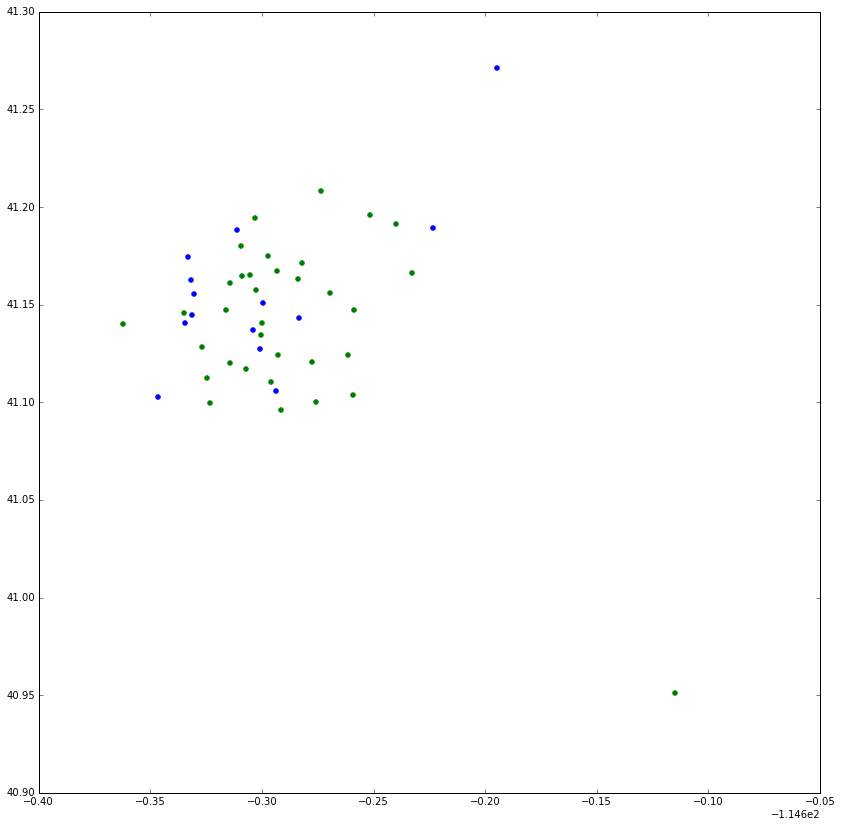

In [37]:
f = plt.figure(figsize=(14, 14))
ax=f.add_subplot(111)
ax.scatter(train_X_wells[:, 0], train_X_wells[:, 1], color="green")
ax.scatter(validation_X_wells[:, 0], validation_X_wells[:, 1], color="blue")
#ax.scatter(test_X_wells[:, 0], test_X_wells[:, 1], color="red")


In [40]:
print len(train_evids_wells)
cluster_evids = np.loadtxt("/home/dmoore/python/sigvisa/train_clusters/cluster_017")
print len(cluster_evids)

34
47


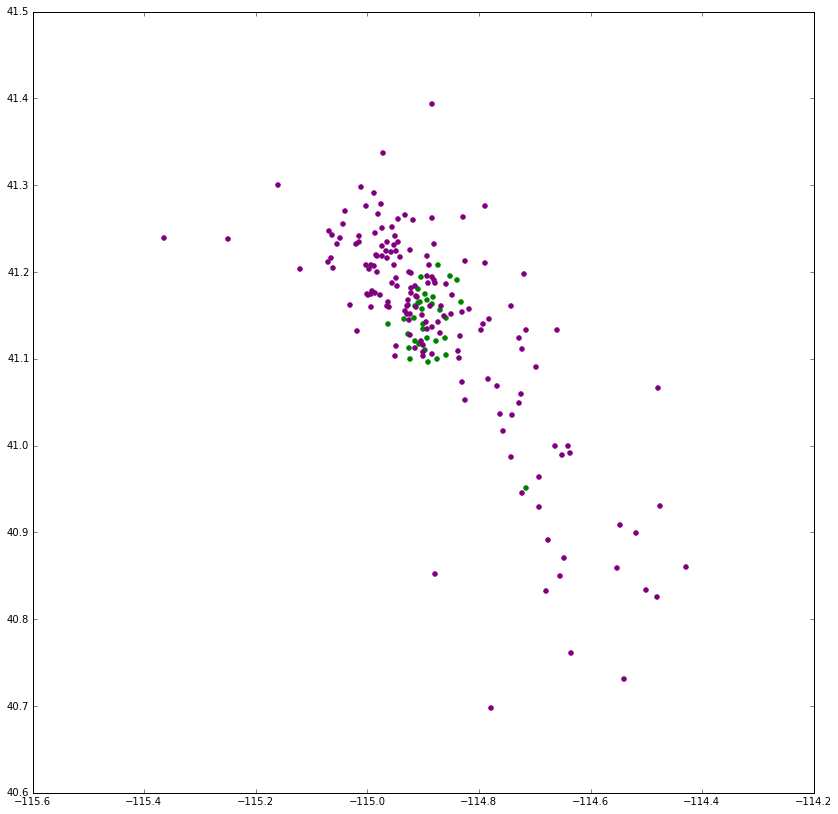

In [41]:
s = Sigvisa()
leb_query = "select lon, lat from leb_origin where lon between -115.5 and -114 and lat between 40.5 and 41.5"
leb_X = np.array(s.sql(leb_query))
f = plt.figure(figsize=(14, 14))
ax=f.add_subplot(111)
ax.scatter(train_X_wells[:, 0], train_X_wells[:, 1], color="green")
ax.scatter(leb_X[:, 0], leb_X[:, 1], color="purple")